In [1]:
import sys
sys.path.append("../")

from langgraph_swarm import Agent, create_swarm_workflow, tool, get_agent_name_from_message
from langgraph_swarm.repl import run_demo_loop
from langchain_openai import ChatOpenAI

In [2]:
@tool
def process_refund(item_id: str, reason: str="NOT SPECIFIED"):
    """
    Refund an item. Refund an item. Make sure you have the item_id of the form item_... Ask for user confirmation before processing the refund.
    
    Args:
        item_id: The ID of the item to refund.
        reason: The reason for the refund. Defaults to "NOT SPECIFIED".
    """
    print(f"[mock] Refunding item {item_id} because {reason}...")
    return "Success!"

@tool
def apply_discount():
    """
    Apply a discount to the user's cart.
    
    Args:
        None
    """
    print("[mock] Applying discount...")
    return "Applied discount of 11%"



triage_agent = Agent(
    name="Triage Agent",
    instructions="Determine which agent is best suited to handle the user's request, and transfer the conversation to that agent.",
    backlink=False
)
sales_agent = Agent(
    name="Sales Agent",
    instructions="Be super enthusiastic about selling bees.",
    backlink=True
)
refunds_agent = Agent(
    name="Refunds Agent",
    instructions="Help the user with a refund. If the reason is that it was too expensive, offer the user a refund code. If they insist, then process the refund.",
    backlink=True
    # functions=[process_refund, apply_discount],
)


triage_agent.handoffs = [sales_agent, refunds_agent]
refunds_agent.functions = [process_refund, apply_discount]

## create a swarm workflow and run the agents

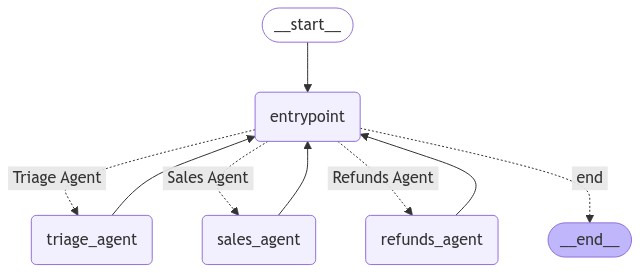

In [6]:
from langchain_core.messages import HumanMessage

llm = ChatOpenAI(temperature=0.3, model_name="llama3.2:latest", openai_api_key="OPENAI_API_KEY", base_url="http://localhost:11434/v1")
def print_messages(messages):
    for message in messages:
        agent_name = get_agent_name_from_message(messages[0]) or "User"
        print(f"{agent_name}[{message.type}]: {message}")

wf = create_swarm_workflow(
        llm=llm,
        starting_agent=triage_agent,
        print_messages=print_messages,
        with_user_agent=False,
        debug=True,
)

from IPython.display import Image, display
image = wf.get_graph(xray=True).draw_mermaid_png()
display(Image(image))

In [ ]:

user_inputs = [
    "I need a refund",
    "Fine, it's done. and I want to talk to sales",
    "I want to talk to sales",    
    "/end",
]
messages = [HumanMessage(content=user_inputs[0], name="User ")]
wf.invoke(input={"messages": messages, "agent_name": triage_agent.name, "handoff": True})

# use run_demo_loop function instead

In [4]:
user_inputs = [
    "I need a refund for item_12345",
    "Fine, it's done. and I want to talk to sales",
    "I want to talk to sales",    
    "/end",
]

run_demo_loop(starting_agent=triage_agent, debug=True, user_inputs=user_inputs)

User[human]: content='I need a refund for item_12345' additional_kwargs={} response_metadata={} name='User'
[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'agent_name': 'Triage Agent',
 'handoff': True,
 'messages': [HumanMessage(content='I need a refund for item_12345', additional_kwargs={}, response_metadata={}, name='User')]}
[0:writes] Finished step 0 with writes to 3 channels:
- messages -> [HumanMessage(content='I need a refund for item_12345', additional_kwargs={}, response_metadata={}, name='User')]
- agent_name -> 'Triage Agent'
- handoff -> True
[0:checkpoint] State at the end of step 0:
{'agent_name': 'Triage Agent',
 'handoff': True,
 'messages': [HumanMessage(content='I need a refund for item_12345', additional_kwargs={}, response_metadata={}, name='User')]}
[1:tasks] Starting step 1 with 1 task:
- entrypoint -> {'agent_name': 'Triage Agent',
 'handoff': True,
 'messages': [HumanMessage(content='I need a refund for it